# Intervention


In [1]:
import torch, transformer_lens, itertools
from measureLM import visualizing, decoding, patching, scoring

In [38]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-medium").to("cpu")
model.cfg.spacing = "Ġ"
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  cpu


### 1) Get activations


prompt 0
layer 23: [(0.0005, 'awesome'), (0.0005, 'excellent'), (0.0003, 'awful'), (1.0, '0'), (0.5, '1')]


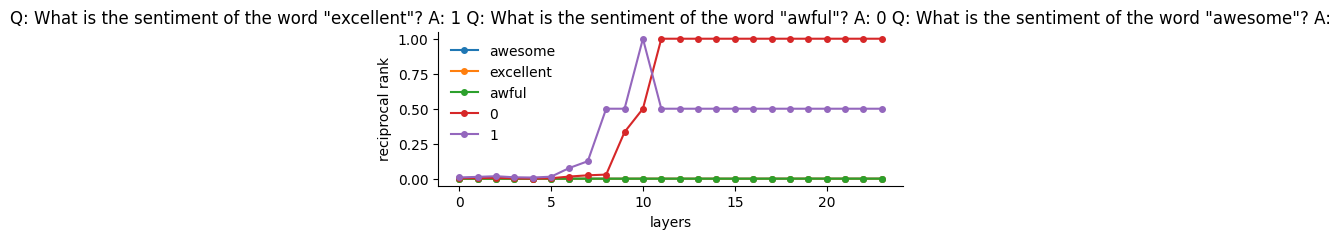

In [45]:
args = [("excellent","1"), ("awful","0"), ("awesome","1")]
prompts = [f'Q: What is the sentiment of the word "{args[0][0]}"? A: {args[0][1]} Q: What is the sentiment of the word "{args[1][0]}"? A: {args[1][1]} Q: What is the sentiment of the word "{args[2][0]}"? A:']

#args = [("excellent","1"), ("awful","0"), ("bad","0")]
#prompts = [f'The sentiment of {args[0][0]} is {args[0][1]}. The sentiment of {args[1][0]} is {args[1][1]}. The sentiment of {args[2][0]} is']

logits, activs, tokens = decoding.encode(prompts, model)
layer_scores = decoding.early_decoding(activs, model)
token_candidates = list(set(itertools.chain(*args)))

tok_idx = scoring.token_select(tokens, model)
scored_tokens = scoring.scores_to_tokens(layer_scores, tok_idx, model, mode=token_candidates)
visualizing.visualize_token_ranks(scored_tokens, token_candidates, prompts)

### (2) Use activations to intervene

['Ġa', 'Ġnot', 'Ġthe']
patching blocks.15.hook_mlp_out <-- blocks.15.hook_mlp_out
patching blocks.16.hook_mlp_out <-- blocks.16.hook_mlp_out
patching blocks.17.hook_mlp_out <-- blocks.17.hook_mlp_out
patching blocks.18.hook_mlp_out <-- blocks.18.hook_mlp_out
patching blocks.19.hook_mlp_out <-- blocks.19.hook_mlp_out
patching blocks.20.hook_mlp_out <-- blocks.20.hook_mlp_out
patching blocks.21.hook_mlp_out <-- blocks.21.hook_mlp_out
patching blocks.22.hook_mlp_out <-- blocks.22.hook_mlp_out
patching blocks.23.hook_mlp_out <-- blocks.23.hook_mlp_out
['Ġ-', 'Ġa', 'Ġ3']

prompt 0
layer 23: [(0.0008, 'awesome'), (0.0006, 'excellent'), (0.0002, 'awful'), (0.0263, '0'), (0.25, '1')]


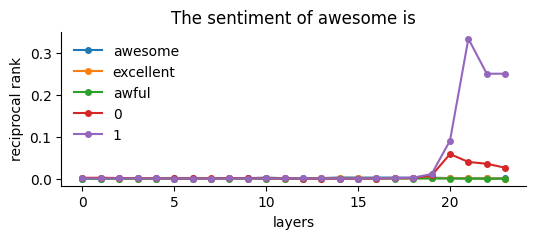

In [46]:
new_prompts = [f'The sentiment of {args[2][0]} is']
new_logits, new_activs, new_tokens = decoding.encode(new_prompts, model)
pred = model.tokenizer.convert_ids_to_tokens(torch.topk(new_logits[:, -1, :], k=3).indices.tolist()[0])
print(pred)

patch_map = patching.create_hook_mapping(model, patch_l=(15, 25))
patch_logits, resid_post = patching.intervene(new_tokens, activs, model, patch_map, extract_tok_idx=-1)
resid_layer_scores = decoding.early_decoding(resid_post, model)

pred = model.tokenizer.convert_ids_to_tokens(torch.topk(patch_logits[:, -1, :], k=3).indices.tolist()[0])
print(pred)

new_token_candidates = token_candidates

## scoring
tok_idx = scoring.token_select(new_tokens, model)
scored_tokens = scoring.scores_to_tokens(resid_layer_scores, tok_idx, model, mode=new_token_candidates)
visualizing.visualize_token_ranks(scored_tokens, new_token_candidates, new_prompts)
